# En prenant en compte l'heure et la date comment maximiser le pourcentage de contacter au premier appel.

### Chargement et Préparation des Données

In [1]:
import pandas as pd

# Chargement des données du premier appel
calls_a1 = pd.read_csv('./calls_a1.csv/calls_a1.csv')

# Conversion des variables catégorielles
var_cat = ["weekday_a1", "hour_a1", "lead_answered_a1"]
for var in var_cat:
    calls_a1[var] = calls_a1[var].astype('category')

calls_a1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6312590 entries, 0 to 6312589
Data columns (total 7 columns):
 #   Column            Dtype   
---  ------            -----   
 0   lead_id           object  
 1   date_a1           object  
 2   weekday_a1        category
 3   hour_a1           category
 4   duration_a1       int64   
 5   caller_id_a1      object  
 6   lead_answered_a1  category
dtypes: category(3), int64(1), object(3)
memory usage: 210.7+ MB


### Création du Modèle Bayésien

In [2]:
import pyAgrum as gum

# Définir les variables pour le modèle
var_to_model = ["weekday_a1", "hour_a1", "lead_answered_a1"]

# Créer les variables du réseau bayésien
var_bn = {}
for var in var_to_model:
    nb_values = len(calls_a1[var].cat.categories)
    var_bn[var] = gum.LabelizedVariable(var, var, nb_values)

# Renseigner les modalités des variables
for var in var_bn:
    for i, modalite in enumerate(calls_a1[var].cat.categories):
        var_bn[var].changeLabel(i, modalite)

# Créer le réseau bayésien et ajouter les variables
bn = gum.BayesNet("model_first_call")
for var in var_bn.values():
    bn.add(var)

# Fixer la structure
bn.addArc("weekday_a1", "lead_answered_a1")
bn.addArc("hour_a1", "lead_answered_a1")


### Apprentissage des Paramètres

In [3]:
# Utiliser BNLearner pour apprendre les paramètres des LPC
learner = gum.BNLearner(calls_a1[var_to_model])
learner.fitParameters(bn)

# Afficher les LPC apprises
print(bn.cpt("weekday_a1"))
print(bn.cpt("hour_a1"))
print(bn.cpt("lead_answered_a1"))



  weekday_a1                                     |
0Monday  |1Tuesday |2Wednesda|3Thursday|4Friday  |
---------|---------|---------|---------|---------|
 0.1835  | 0.2109  | 0.2114  | 0.2071  | 0.1871  |


  hour_a1                                                                                |
h10      |h11      |h12      |h14      |h15      |h16      |h17      |h18      |h19      |
---------|---------|---------|---------|---------|---------|---------|---------|---------|
 0.1099  | 0.1256  | 0.1255  | 0.0838  | 0.1189  | 0.1215  | 0.0900  | 0.1155  | 0.1091  |


             ||  lead_answered_a1 |
weekda|hour_a||no       |yes      |
------|------||---------|---------|
0Monda|h10   || 0.7627  | 0.2373  |
1Tuesd|h10   || 0.7717  | 0.2283  |
2Wedne|h10   || 0.7595  | 0.2405  |
3Thurs|h10   || 0.7825  | 0.2175  |
4Frida|h10   || 0.7815  | 0.2185  |
0Monda|h11   || 0.7608  | 0.2392  |
[...33 more line(s) ...]
4Frida|h18   || 0.7665  | 0.2335  |
0Monda|h19   || 0.7640  | 0.2360  |
1Tuesd

### Prédictions

In [4]:
import numpy as np
import sys

def predict(bn, data, var_target, show_progress=False):
    """
    Cette fonction prédit la probabilité postérieure d'une variable cible à partir des observations
    en utilisant un modèle de réseau bayésien.
    """
    # Initialiser le moteur d'inférence
    inf_bn = gum.LazyPropagation(bn)
    inf_bn.setTargets({var_target})
    nb_data = len(data)
    target_size = bn.variable(var_target).domainSize()
    target_dom = np.array([bn.variable(var_target).label(i) for i in range(target_size)])
    data_records = data.to_dict("records")
    post_prob = np.zeros((nb_data, target_size))
    
    for i in range(nb_data):
        inf_bn.setEvidence(data_records[i])
        inf_bn.makeInference()
        post_prob[i, :] = inf_bn.posterior(var_target).toarray()
        inf_bn.eraseAllEvidence()
        if show_progress:
            sys.stdout.write("predict progress: {0:3.0%}\r".format(i/nb_data))

    post_prob_df = pd.DataFrame(post_prob, index=data.index, columns=bn.variable(var_target).labels())
    post_prob_df.columns.name = var_target
    return post_prob_df

# Utiliser les premières lignes des données pour les prédictions
pred_prob = predict(bn, data=calls_a1.loc[:10000, ["weekday_a1", "hour_a1"]], var_target="lead_answered_a1", show_progress=True)

# Prédictions finales
pred_var = pred_prob.idxmax(axis=1).rename("pred")

# Évaluer le taux de prédictions correctes
accuracy = (calls_a1.loc[:10000, "lead_answered_a1"] == pred_var).mean()
print("Accuracy:", accuracy)

# Matrice de confusion
confusion_matrix = pd.crosstab(calls_a1.loc[:10000, "lead_answered_a1"], pred_var)
print(confusion_matrix)

Accuracy: 0.7442255774422558
pred                no
lead_answered_a1      
no                7443
yes               2558


### --- --- ---

### Générer les Combinaisons de Jours et Heures

In [5]:
import itertools
import pandas as pd

# Générer toutes les combinaisons possibles de jours et d'heures
weekdays = calls_a1['weekday_a1'].cat.categories
hours = calls_a1['hour_a1'].cat.categories

combinations = list(itertools.product(weekdays, hours))
test_data = pd.DataFrame(combinations, columns=['weekday_a1', 'hour_a1'])

# Convertir les colonnes en type 'category'
test_data['weekday_a1'] = test_data['weekday_a1'].astype('category')
test_data['hour_a1'] = test_data['hour_a1'].astype('category')


### Prédire les Probabilités

In [6]:
# Utiliser la fonction predict pour obtenir les probabilités de réponse
pred_prob = predict(bn, data=test_data, var_target='lead_answered_a1', show_progress=False)

# Ajouter les probabilités de réponse à test_data
test_data['prob_no'] = pred_prob['no']
test_data['prob_yes'] = pred_prob['yes']


### Trouver les Combinaisons Optimales

In [7]:
# Trier les combinaisons par probabilité décroissante de réponse positive
optimal_times = test_data.sort_values(by='prob_yes', ascending=False)
print(optimal_times.head(10))

    weekday_a1 hour_a1   prob_no  prob_yes
2      0Monday     h12  0.751734  0.248266
6      0Monday     h17  0.752140  0.247860
19  2Wednesday     h11  0.755945  0.244055
4      0Monday     h15  0.756006  0.243994
18  2Wednesday     h10  0.759452  0.240548
23  2Wednesday     h16  0.760297  0.239703
16    1Tuesday     h18  0.760313  0.239687
5      0Monday     h16  0.760712  0.239288
1      0Monday     h11  0.760780  0.239220
20  2Wednesday     h12  0.761851  0.238149


### Combinaisons de jours et heures les plus probables pour réussir un appel

    weekday_a1 hour_a1   prob_no  prob_yes
2      0Monday     h12  0.751734  0.248266
6      0Monday     h17  0.752140  0.247860
19  2Wednesday     h11  0.755945  0.244055
4      0Monday     h15  0.756006  0.243994
18  2Wednesday     h10  0.759452  0.240548
23  2Wednesday     h16  0.760297  0.239703
16    1Tuesday     h18  0.760313  0.239687
5      0Monday     h16  0.760712  0.239288
1      0Monday     h11  0.760780  0.239220
20  2Wednesday     h12  0.761851  0.238149


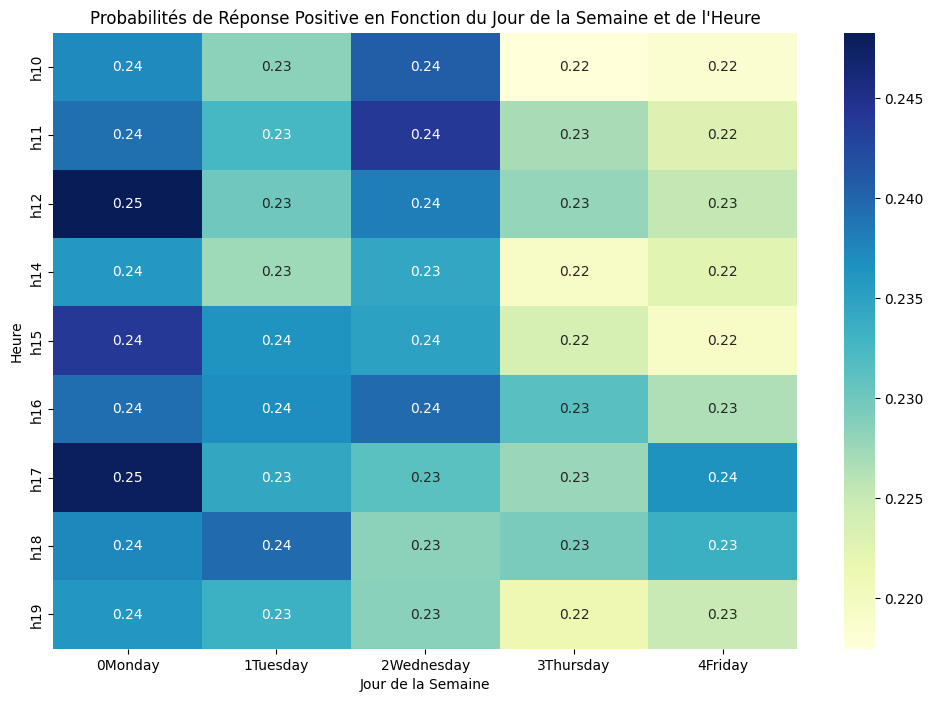

In [9]:
# Visualisation des probabilités de réponse positive en fonction du jour de la semaine et de l'heure
import matplotlib.pyplot as plt
import seaborn as sns

# Générer toutes les combinaisons possibles de jours et d'heures
weekdays = calls_a1['weekday_a1'].cat.categories
hours = calls_a1['hour_a1'].cat.categories
combinations = list(itertools.product(weekdays, hours))
test_data = pd.DataFrame(combinations, columns=['weekday_a1', 'hour_a1'])

# Convertir les colonnes en type 'category'
test_data['weekday_a1'] = test_data['weekday_a1'].astype('category')
test_data['hour_a1'] = test_data['hour_a1'].astype('category')

# Utiliser la fonction predict pour obtenir les probabilités de réponse
pred_prob = predict(bn, data=test_data, var_target='lead_answered_a1', show_progress=False)

# Ajouter les probabilités de réponse à test_data
test_data['prob_no'] = pred_prob['no']
test_data['prob_yes'] = pred_prob['yes']

# Trier les combinaisons par probabilité décroissante de réponse positive
optimal_times = test_data.sort_values(by='prob_yes', ascending=False)
print(optimal_times.head(10))  # Afficher les 10 combinaisons avec les plus hautes probabilités de réponse

# Visualisation des probabilités de réponse positive en fonction du jour de la semaine et de l'heure
plt.figure(figsize=(12, 8))
heatmap_data = test_data.pivot(index="hour_a1", columns="weekday_a1", values="prob_yes")
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Probabilités de Réponse Positive en Fonction du Jour de la Semaine et de l'Heure")
plt.ylabel("Heure")
plt.xlabel("Jour de la Semaine")
plt.show()